---
title: Metropolis--Hastings Algorithm
date: 2025-03-27
---

In [15]:
import numpy as np
import matplotlib.pyplot as plt


## Problem 1

Consider the following density function:
$$
f(x, y) = c \exp\left[-0.5(x^2y^2 + x^2 + y^2 -8x - 8y) \right]
$$
where $c$ is the normalization constant. 

1. Write the Metropolis-Hastings algorithm to sample from the distribution $f(x, y)$. 
   Note that you do not need to compute the normalization constant for running the Metropolis-Hastings algorithm.
2. Do the following steps for 1) Gaussian proposal and 2) uniform proposal: 
   1. Plot the samples generated by the algorithm in the $x$-$y$ plane.
   2. Plot the running average of the $x$ and $y$ coordinates of the samples. 
   3. Generate enough samples so that the running averages look stable. 
   4. Report the acceptance rate of the algorithm. Play around with the proposal distribution parameters to get a good acceptance rate (around 0.2-0.5).
  
You can simply use product of Gaussians and product of uniform distributions as proposal distributions. 

In [16]:
class MetropolisHastings:
  def __init__(self, seed=0):
    self.rng = np.random.default_rng(seed)

  def target_distribution(self, x, y):
    """The unnormalized target distribution f(x, y)."""
    return np.exp(-0.5 * (x**2 * y**2 + x**2 + y**2 - 8*x - 8*y))
  
  def proposal_generator_normal(self, x, y, std):
    """Generate a new proposal from normal distribution centered at (x, y) with given std."""
    new_x = self.rng.normal(x, std)
    new_y = self.rng.normal(y, std)
    return new_x, new_y

  def proposal_generator_uniform(self, x, y, width):
    """Generate a new proposal from uniform distribution within a square of given width centered at (x, y)."""
    half_width = width / 2
    new_x = self.rng.uniform(x - half_width, x + half_width)
    new_y = self.rng.uniform(y - half_width, y + half_width)
    return new_x, new_y

  def accept_reject(self, old_x, old_y, new_x, new_y):
    """Accept or reject the new proposal based on the Metropolis-Hastings criterion."""
    py = self.target_distribution(new_x, new_y)
    px = self.target_distribution(old_x, old_y)
    if py >= px:
      return True
    else:
      u = self.rng.uniform(0, 1)
      return u < py / px

  def rvs(self, N, x_0, y_0, width=1.0, uniform=True):
    """Generate N samples using the Metropolis-Hastings algorithm."""
    x_samples, y_samples = np.zeros(N), np.zeros(N)
    accepted = 1
    for i in range(1, N):
      old_x, old_y = x_samples[i-1], y_samples[i-1]
      if uniform:
        new_x, new_y = self.proposal_generator_uniform(old_x, old_y, width)
      else:
        new_x, new_y = self.proposal_generator_normal(old_x, old_y, width)
      
      if self.accept_reject(old_x, old_y, new_x, new_y):
        x_samples[i], y_samples[i] = new_x, new_y
        accepted += 1
      else:
        x_samples[i], y_samples[i] = old_x, old_y
    acceptance_rate = accepted / N
    return x_samples, y_samples, acceptance_rate



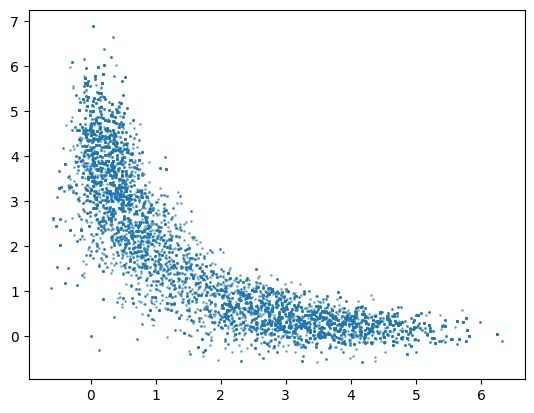

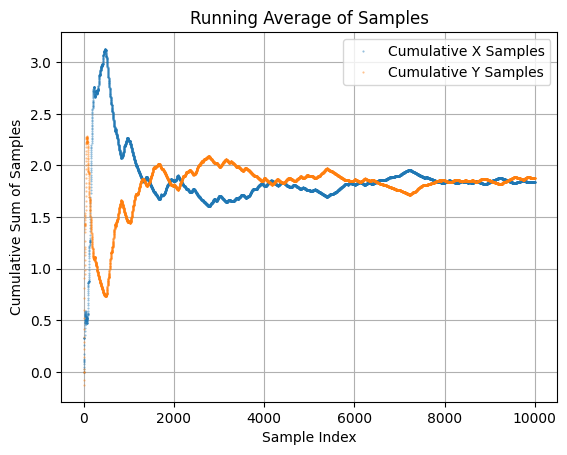

Acceptance rate: 0.3046


In [17]:
# Generate samples from a 2D normal distribution using Metropolis-Hastings
# Plot samples, running average of x and y
# Report the acceptance rate
N = 10000
mh = MetropolisHastings(seed=42)
x_0, y_0 = 0, 0  # Starting point
x_samples, y_samples, acceptance_rate = mh.rvs(N, x_0, y_0, width=1.0, uniform=False)

# Plotting the samples
plt.scatter(x_samples, y_samples, s=1, alpha=0.5)
plt.show()

s_range = np.array(range(1, N+1))
plt.plot(s_range, np.cumsum(x_samples) / s_range, 'o', markersize=0.5, alpha=0.5)
plt.plot(s_range, np.cumsum(y_samples) / s_range, 'o', markersize=0.5, alpha=0.5)
plt.title("Running Average of Samples")
plt.xlabel("Sample Index")
plt.ylabel("Cumulative Sum of Samples")
plt.legend(['Cumulative X Samples', 'Cumulative Y Samples'])
plt.grid()
plt.show()
print(f"Acceptance rate: {acceptance_rate:.4f}")




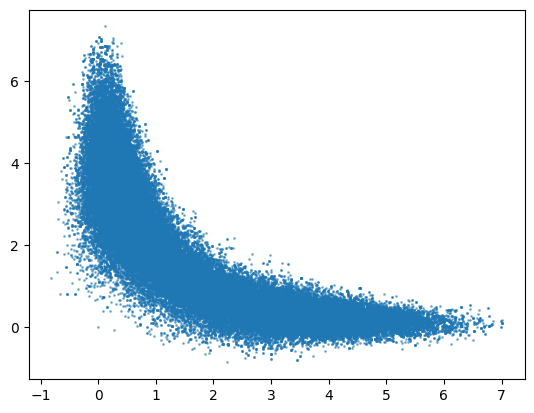

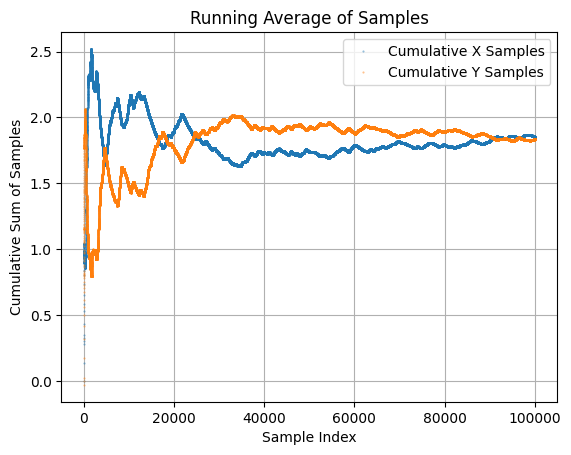

Acceptance rate: 0.6577


In [18]:
# Generate samples from a 2D uniform distribution using Metropolis-Hastings
# Plot samples, running average of x and y
# Report the acceptance rate
N = 100000
mh = MetropolisHastings(seed=42)
x_0, y_0 = 0, 0  # Starting point
x_samples, y_samples, acceptance_rate = mh.rvs(N, x_0, y_0, width=1.0, uniform=True)

# Plotting the samples
plt.scatter(x_samples, y_samples, s=1, alpha=0.5)
plt.show()

s_range = np.array(range(1, N+1))
plt.plot(s_range, np.cumsum(x_samples) / s_range, 'o', markersize=0.5, alpha=0.5)
plt.plot(s_range, np.cumsum(y_samples) / s_range, 'o', markersize=0.5, alpha=0.5)
plt.title("Running Average of Samples")
plt.xlabel("Sample Index")
plt.ylabel("Cumulative Sum of Samples")
plt.legend(['Cumulative X Samples', 'Cumulative Y Samples'])
plt.grid()
plt.show()
print(f"Acceptance rate: {acceptance_rate:.4f}")


## Problem 2: Ising Model

In a previous worksheet you implemented the Gibbs sampling algorithm for the Ising model. In this problem, you will implement the Metropolis-Hastings algorithm for the Ising model. We'll only test the results near the critical temperature. Use the proposal distribution and update criteria as in the written assignment. As before, there is no need to store the states of the system. We update the lattice in place and simply keep track of the magnetization.

**Very Important:** MH algorithm only updates one spin at a time. This will lead to extremely high autocorrelation and extremely high mixing time. Instead, do $N^2$ updates  where $N$ is the number of spins in the system and think of the $N^2$ updates as one iteration.

1. Plot the magnetization of the system as a function of the sample number.
2. Plot the running average of the magnetization. 
3. Generate enough samples so that the running averages look stable.

You should make your own assessments about the number of samples to generate. 

In [19]:
class IsingModel_Metropolis:
    def __init__(self, L, T, J=1, random=False):
        self.L = L # Lattice size
        self.T = T # Temperature
        self.J = J # Interaction strength
        self.rng = np.random.default_rng()
        self.initialize(random=random) # Initialize the lattice
        
    def initialize(self, random=False):
         # either initialize with random spins or all spins up
        if random:
            # randomly choose from -1 or 1
            self.lattice = self.rng.choice([-1, 1], size=(self.L, self.L))
        else:
            self.lattice = np.ones((self.L, self.L), dtype=int)
        
    def magnetization(self):
        return np.mean(self.lattice)
    
    def hamiltonian(self, lattice):
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                # Periodic boundary conditions
                right = (i + 1) % self.L
                down = (j + 1) % self.L
                left = (i - 1) % self.L
                up = (j - 1) % self.L
                # Calculate energy contribution from neighbors
                energy -= self.J * lattice[i, j] * (lattice[right, j] + lattice[i, down] + lattice[left, j] + lattice[i, up])
        return energy
        
    def metropolis_hasting_step(self):
        x, y = self.rng.integers(0, self.L, size=2) # uniform over lattice
        proposal_lattice = np.copy(self.lattice)
        proposal_lattice[x, y] *= -1
        ratio = np.exp(-(self.hamiltonian(proposal_lattice) - self.hamiltonian(self.lattice)) / self.T)
        if ratio >= 1.0: # Always accept if the new state has lower energy
            self.lattice = proposal_lattice
        else:
            u = self.rng.uniform(0, 1)
            if u < ratio:
                self.lattice = proposal_lattice

    def simulate_constant_T(self, N, burn_in=0, sampling_interval=None):
        sampling_interval = N**2
        mag = np.zeros(sampling_interval)
        for _ in range(burn_in * self.L**2):
            # Perform burn-in steps to reach equilibrium
            self.metropolis_hasting_step()
        for i in range(sampling_interval):
            for _ in range(self.L**2):
                # Perform Metropolis-Hastings steps to sample from the distribution
                self.metropolis_hasting_step()
            # each iteration
            mag[i] = self.magnetization()
        return mag
        
    def plot_lattice(self):
        plt.imshow(self.lattice, cmap='gray')
        plt.show()

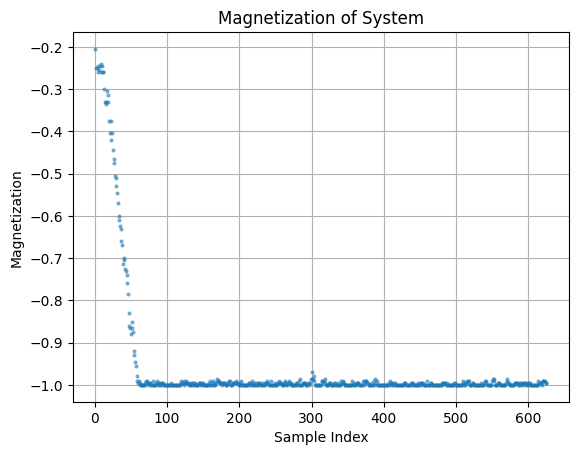

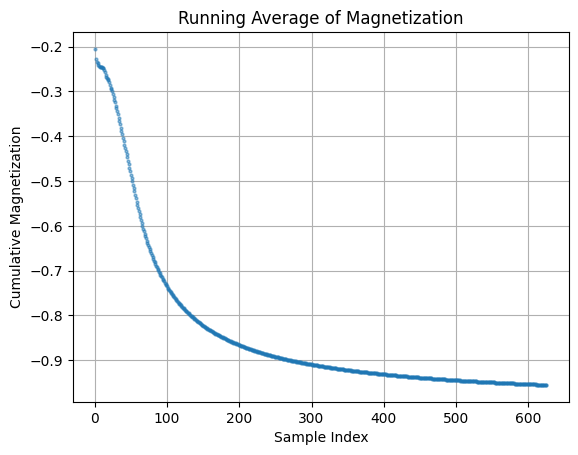

Final Magnetization: -0.9950


In [20]:
# Parameters
L = 20  # Lattice size

# Critical Temperature for 2D Ising Model
Tc = 2 / np.log(1 + np.sqrt(2))  # ~2.269

# run Gibbs sampler close to critical temperature
T = Tc + 0.1

# Generate samples from the Ising model using Metropolis-Hastings
# Plot samples, running average of magnetization
mh_ising = IsingModel_Metropolis(L, T, random=True)
N = 25  # Number of samples
magnetization_samples = mh_ising.simulate_constant_T(N, burn_in=10)
s_range = range(1, N**2 + 1)  # Sample indices for plotting

plt.plot(s_range, magnetization_samples, 'o', markersize=2, alpha=0.5)
plt.title("Magnetization of System")
plt.xlabel("Sample Index")
plt.ylabel("Magnetization")
plt.grid()
plt.show()

plt.plot(s_range, np.cumsum(magnetization_samples) / np.array(s_range), 'o', markersize=2, alpha=0.5)
plt.title("Running Average of Magnetization")
plt.xlabel("Sample Index")
plt.ylabel("Cumulative Magnetization")
plt.grid()
plt.show()

print(f"Final Magnetization: {magnetization_samples[-1]:.4f}")
